In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
device = torch.device("cuda")

# Obtain Uncompressed $p(\text{sequence}, \text{structure})$ Embedding

In [4]:
# Load ESMFold Embedding-Only Model
from cheap.esmfold import esmfold_v1_embed_only

esmfold_embedder = esmfold_v1_embed_only()
_ = esmfold_embedder.to(device)

Creating ESMFold embedding only model...
ESMFold embedding only model created in 28.40 seconds


In [5]:
sequences = [
    # >cath|current|12asA00/4-330
    "AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQTLGQHDFSAGEGLYTHMKALRPDEDRLSPLHSVYVDQWDWERVMGDGERQFSTLKSTVEAIWAGIKATEAAVSEEFGLAPFLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLVGIGGKLSDGHRHDVRAPDYDDWSTPSELGHAGLNGDILVWNPVLEDAFELSSMGIRVDADTLKHQLALTGDEDRLELEWHQALLRGEMPQTIGGGIGQSRLTMLLLQLPHIGQVQAGVWPAAVRESVPSLL",
    # >cath|current|132lA00/2-129
    "VFGRCELAAAMRHGLDNYRGYSLGNWVCAAFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKIVSDGNGMNAWVAWRNRCGTDVQAWIRGCRL",
    # >cath|current|153lA00/1-185
    "RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMDRYKTIIKKVGEKLCVEPAVIAGIISRESHAGKVLKNGWGDRGNGFGLMQVDKRSHKPQGTWNGEVHITQGTTILINFIKTIQKKFPSWTKDQQLKGGISAYNAGAGNVRSYARMDIGTTHDDYANDVVARAQYYKQHGY",
]

In [6]:
res = esmfold_embedder.infer_embedding(sequences)
emb, mask = res['s'], res['mask']
emb, mask = emb.to(device), mask.to(device)

In [7]:
print(emb.shape)
print(mask.shape)

torch.Size([3, 327, 1024])
torch.Size([3, 327])


The sequences have been automatically padded to the longest sequence in the batch.
If you are running out of memory, consider trimming the sequences prior to this embedding inference operation.

In [8]:
sequence_lengths = mask.sum(dim=1)
print(sequence_lengths)

tensor([327, 124, 185], device='cuda:0')


## Sanity Check Predictions

In [9]:
from cheap.proteins import LatentToStructure, LatentToSequence

# !!!! important !!!!
# this implicitly creates the ESMFold model again, which might take up a lot of memory.
# Must explicitly call `.to(device)` on this wrapper API; models are by default loaded to the CPU. 
latent_to_structure = LatentToStructure()
latent_to_structure.to(device)

# Similarly, this creates the sequence decoder, but it is much smaller than the structure decoder
latent_to_sequence = LatentToSequence()
latent_to_sequence = latent_to_sequence.to(device)

Creating ESMFold...
ESMFold model loaded in 34.26 seconds.
Downloading: "https://huggingface.co/amyxlu/cheap-proteins/resolve/main/sequence_decoder/mlp.ckpt" to /home/amyxlu/.cache/cheap/sequence_decoder/mlp.ckpt
100%|██████████| 7.58M/7.58M [00:00<00:00, 36.6MB/s]


In [10]:
res = latent_to_sequence.to_sequence(emb); assert len(res) == 3

sanity_check_sequences = res[-1]
for i, s in enumerate(sanity_check_sequences):
    sanity_check_sequences[i] = s[:sequence_lengths[i]]

print(sanity_check_sequences)

['AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQTLGQHDFSAGEGLYTHMKALRPDEDRLSPLHSVYVDQWDWERVMGDGERQFSTLKSTVEAIWAGIKATEAAVSEEFGLAPFLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLVGIGGKLSDGHRHDVRAPDYDDWSTPSELGHAGLNGDILVWNPVLEDAFELSSMGIRVDADTLKHQLALTGDEDRLELEWHQALLRGEMPQTIGGGIGQSRLTMLLLQLPHIGQVQAGVWPAAVRESVPSLL', 'VFGRCELAAAMRHGLDNYRGYSLGNWVCAAFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKIVSDGNGMNAWVAWRNRCGTDVQAWIRGCRL', 'RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMDRYKTIIKKVGEKLCVEPAVIAGIISRESHAGKVLKNGWGDRGNGFGLMQVDKRSHKPQGTWNGEVHITQGTTILINFIKTIQKKFPSWTKDQQLKGGISAYNAGAGNVRSYARMDIGTTHDDYANDVVARAQYYKQHGY']


In [12]:
from cheap.utils import calc_sequence_recovery

# sequence decoder gets perfect decoding accuracy:
for orig_s, sanity_s in zip(sequences, sanity_check_sequences):
    print(calc_sequence_recovery(orig_s, sanity_s))

1.0
1.0
1.0


## Massive Activations

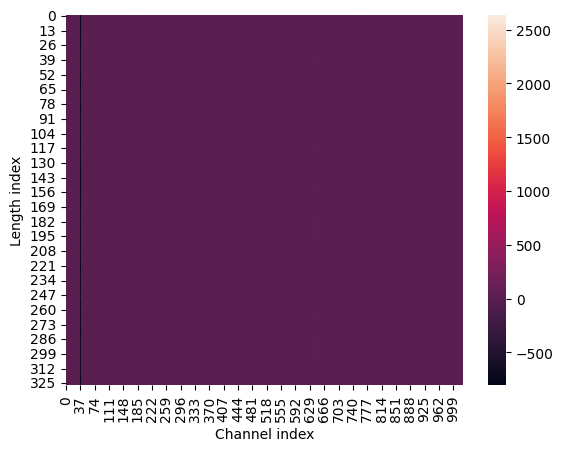

In [ ]:
# just for fun, let's examine the massive activations:
import seaborn as sns
import matplotlib.pyplot as plt

_ = sns.heatmap(emb[0].cpu().numpy())
_ = plt.ylabel("Length index")
_ = plt.xlabel("Channel index")

torch.Size([1024])
2183.554931640625 -665.0863037109375


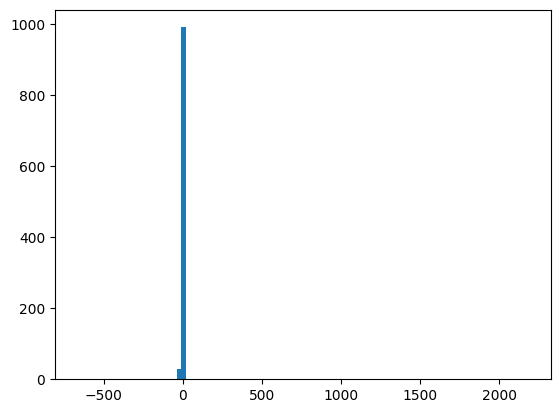

In [ ]:
chan_means = emb.mean(dim=(0,1))
print(chan_means.shape)
print(chan_means.max().item(), chan_means.min().item())
_ = plt.hist(chan_means.cpu().numpy(), bins=100)